# Statistical analysis

### Difference between BERT+ResNet-152 and CLIP versions of models

In [1]:
import scipy as sp
import pandas as pd
import numpy as np
from src.definitions import ROOT_DIR
from pathlib import PurePosixPath
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def plot_dist(model1:np.ndarray, model2:np.ndarray, filter_quantiles:float=0.01) -> None:
    min_val = np.quantile(model1-model2, filter_quantiles)
    max_val = np.quantile(model1-model2, 1-filter_quantiles)
    ar = model1-model2
    ar = ar[(min_val < ar) & (ar < max_val)]
    sns.displot(ar, kind="kde")
    plt.show()

##### Simple concatenation

In [3]:
from src.models.bert import FPBERTResNet152ConcatModel
from src.models.clip import FPCLIPConcatModel

# run_01: 61480.37 vs. run_02: 58109.56
simple_bert_resnet152 = FPBERTResNet152ConcatModel.load_from_best_checkpoint(run="run_02")
simple_bert_resnet152.hparams.update({"store_submission_frame": False})
sub_simple_bert_resnet152 = simple_bert_resnet152.make_submission_frame()
del simple_bert_resnet152
res_simple_bert_resnet152 = (
    (sub_simple_bert_resnet152["true"]/100 - sub_simple_bert_resnet152["pred"]/100) ** 2
).values

# run_01: 64375.36 vs. run_02: 63116.73
simple_clip = FPCLIPConcatModel.load_from_best_checkpoint(run="run_02")
simple_clip.hparams.update({"store_submission_frame": False})
sub_simple_clip = simple_clip.make_submission_frame()
del simple_clip
res_simple_clip = (
    (sub_simple_clip["true"]/100 - sub_simple_clip["pred"]/100) ** 2
).values

Global seed set to 42
Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/34 [00:00<?, ?it/s]

Global seed set to 42


  0%|          | 0/34 [00:00<?, ?it/s]

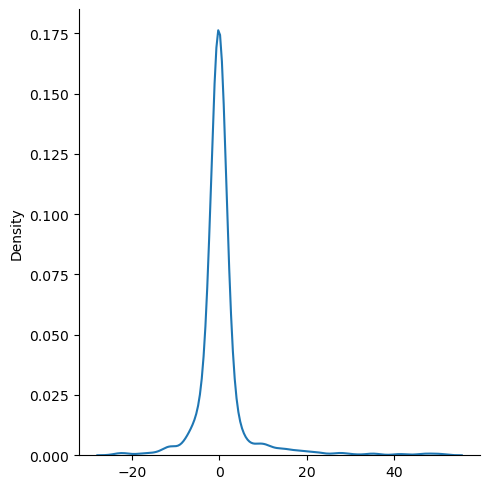

In [4]:
plot_dist(res_simple_clip, res_simple_bert_resnet152)

In [5]:
sp.stats.ttest_rel(
    b=res_simple_bert_resnet152,
    a=res_simple_clip,
    alternative="less"
)

# Theory: CLIP better than BERT+ResNet-152
# H0: BertResNet152 > CLIP
# H1: smaller

Ttest_relResult(statistic=1.7922704392193298, pvalue=0.9633124879795923)

##### Attention-like mechanism

In [6]:
from src.models.bert import FPBERTResNet152WeightedConcatModel
from src.models.clip import FPCLIPWeightedConcatModel

# run_01: 60493.92 vs. run_02: 56450.27
weighted_bert_resnet152 = FPBERTResNet152WeightedConcatModel.load_from_best_checkpoint(run="run_02")
weighted_bert_resnet152.hparams.update({"store_submission_frame": False})
sub_weighted_bert_resnet152 = weighted_bert_resnet152.make_submission_frame()
del weighted_bert_resnet152
res_weighted_bert_resnet152 = (
    (sub_weighted_bert_resnet152["true"]/100 - sub_weighted_bert_resnet152["pred"]/100) ** 2
).values

# run_01: 61844.27 vs. run_02: 54986.56
weighted_clip = FPCLIPWeightedConcatModel.load_from_best_checkpoint(run="run_02")
weighted_clip.hparams.update({"store_submission_frame": False})
sub_weighted_clip = weighted_clip.make_submission_frame()
del weighted_clip
res_weighted_clip = (
    (sub_weighted_clip["true"]/100 - sub_weighted_clip["pred"]/100) ** 2
).values

Global seed set to 42
Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/34 [00:00<?, ?it/s]

Global seed set to 42


  0%|          | 0/34 [00:00<?, ?it/s]

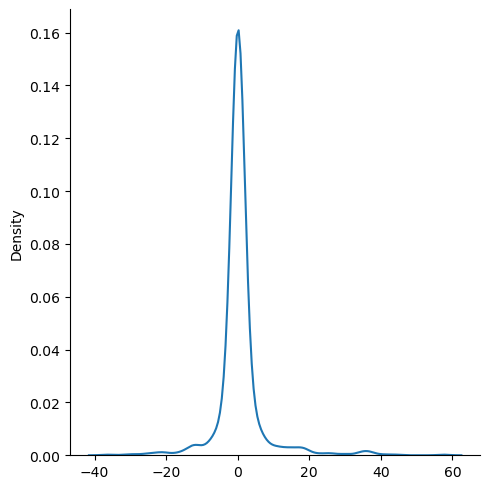

In [7]:
plot_dist(res_weighted_clip, res_weighted_bert_resnet152)

In [8]:
sp.stats.ttest_rel(
    b=res_weighted_bert_resnet152,
    a=res_weighted_clip,
    alternative="less"
)

# Theory: CLIP better than BERT+ResNet-152
# H0: BertResNet152 > CLIP
# H1: smaller

Ttest_relResult(statistic=2.0670616925425955, pvalue=0.9805145480700681)

##### XGB

In [32]:
submissions_fpath = PurePosixPath(ROOT_DIR).joinpath(
    "submissions", "2022-08-27T17:04:06+00:00"
)

xgb_bert_resnet152_fname = submissions_fpath.joinpath("XGBBERTResNet152.csv")
sub_xgb_bert_resnet152 = pd.read_csv(xgb_bert_resnet152_fname, index_col=0, header=0)
res_xgb_bert_resnet152 = (
    (sub_xgb_bert_resnet152["true"]/100 - sub_xgb_bert_resnet152["pred"]/100) ** 2
).values

xgb_clip_fname = submissions_fpath.joinpath("XGBCLIP.csv")
sub_xgb_clip = pd.read_csv(xgb_clip_fname, index_col=0, header=0)
res_xgb_clip = ((sub_xgb_clip["true"]/100 - sub_xgb_clip["pred"]/100) ** 2).values

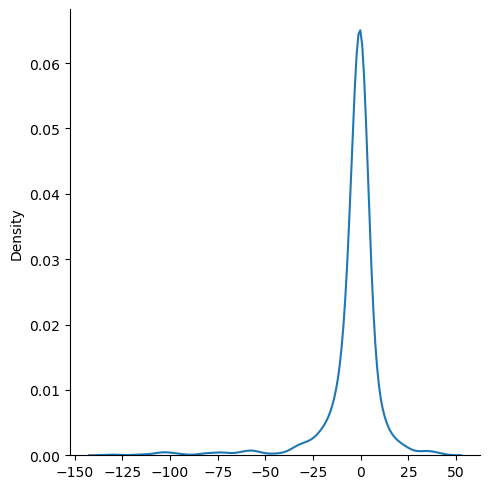

In [33]:
plot_dist(res_xgb_clip, res_xgb_bert_resnet152)

In [34]:
sp.stats.ttest_rel(
    b=res_xgb_bert_resnet152,
    a=res_xgb_clip,
    alternative="less"
)

# Theory: CLIP better than BERT+ResNet-152
# H0: BertResNet152 > CLIP
# H1: smaller

Ttest_relResult(statistic=-4.791208129105644, pvalue=9.469821099365283e-07)